Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.


# SPADE LDM

In this tutorial, we apply SPADE normalisation [1] to a latent diffusion model, in a methodology initially published by Wang et al. [2] to perform semantic image synthesis. 
[1] Park, T., Liu, M.-Y., Wang, T.-C., & Zhu, J.-Y. (2019). Semantic Image Synthesis with Spatially-Adaptive Normalization. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition.

[2] Wang, W., Bao, J., Zhou, W., Chen, D., Chen, D., Yuan, L., & Li, H. (2022). Semantic Image Synthesis via Diffusion Models. https://doi.org/10.48550/arxiv.2207.00050

In [ ]:
import os
import numpy as np

images_dir = '../datasets/MEDNETPAIRS'
labels_dir = '../datasets/MEDNETPAIRS'

# Filter image and label files
image_files = sorted([
    f for f in os.listdir(images_dir)
    if f.endswith('.png') and not f.endswith('_ah.png')
])

label_files = sorted([
    f for f in os.listdir(labels_dir)
    if f.endswith('.png') and f.endswith('_ah.png')
])

# Match images with corresponding labels
# Assuming the label file has the same name as the image with '_ah.png' at the end
input_dict = []
for img_file in image_files:
    base_name = img_file[:-4]  # Remove '.png'
    label_file = f'{base_name}_ah.png'
    if label_file in label_files:
        input_dict.append({
            'img': os.path.join(images_dir, img_file),
            'mask': os.path.join(labels_dir, label_file)
        })

# Shuffle and split
np.random.shuffle(input_dict)
split_point = int(len(input_dict) * 0.8)
input_dict_train = input_dict[:split_point]
input_dict_val = input_dict[split_point:]


## Setup environment 

In [1]:
#!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
#!python -c "import matplotlib" || pip install -q matplotlib
#!python -c "import gdown" || pip install -q gdown
#%matplotlib inline

## Setup imports

In [15]:
import os
import yaml
import tempfile
import zipfile
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
import gdown
import monai
from dataset import *
from preprocessing import *
from monai.config import print_config
from monai.utils import set_determinism
from monai.data import DataLoader
from monai.networks.nets import SPADEAutoencoderKL, SPADEDiffusionModelUNet, PatchDiscriminator
from monai.networks.schedulers import DDPMScheduler
from monai.losses import PatchAdversarialLoss, PerceptualLoss
from monai.inferers import LatentDiffusionInferer

## diosanto
import glob
from monai.transforms import Transform, Compose, Resize, ScaleIntensity, ToTensor, RandAdjustContrast, RandGaussianNoise, RandAffine
from PIL import Image

set_determinism(42)
#print_config()

## Split data and create dictionaries

In [16]:
#root_dir = '../datasets/DRIVE_dataset/datasets/training'
#print("directory used: %s " % root_dir)

In [17]:
# INPUT PARAMETERS
input_shape = [128, 128]
output_shape = (128,128)
batch_size = 4
num_workers = 2

# for one-hot enconding
label_nc = 2

In [24]:
# Load config
with open("configs.yaml", "r") as f:
    config = yaml.safe_load(f)

config["dataset_index"] = 0
dataset = config["dataset_paths"][config["dataset_index"]]
if not os.path.exists(dataset):
    print("Please update your data path to an existing folder.")
elif not set(["training", "test"]).issubset(set(os.listdir(dataset))):
    print("Please update your data path to the correct folder (should contain train and test folders).")
else:
    print(f"Congrats! You selected the correct folder : {dataset}")
    
train_dict_list = build_dict_vessels(dataset, mode='training')
test_dict_list = build_dict_vessels(dataset, mode='test')

print(f'Number of samples in the training dataset: {len(train_dict_list)}')
print(f'Number of samples in the test dataset: {len(test_dict_list)}')

Congrats! You selected the correct folder : ../datasets/fat_DRIVE_dataset/datasets/
Number of samples in the training dataset: 111
Number of samples in the test dataset: 20


## Prepare dataloaders

In [41]:
class LoadVesselData(Transform):
    def __init__(self, output_size=output_shape, add_channel=True, augmentations=None):
        self.output_size = output_size
        self.add_channel = add_channel
        self.augmentations = augmentations if augmentations else []

    def __call__(self, data):
        data = data.copy()
        img_input = data['img']
        mask_input = data.get('mask', None)

        # Process image only if it is a file path, otherwise assume it's already loaded
        if isinstance(img_input, str):
            image = Image.open(img_input).convert('L')
            image = image.resize(self.output_size, resample=Image.Resampling.NEAREST)
            image = np.array(image, dtype=np.float32) / 255.0  # Normalize and cast to float32
        else:
            image = img_input  # already loaded

        if self.add_channel and image.ndim == 2:
            image = np.expand_dims(image, axis=0)  # Add channel dimension [1, H, W]

        # Apply augmentations if any
        if self.augmentations:
            image = torch.from_numpy(image)
            for transform in self.augmentations:
                image = transform(image)
            image = image.numpy()
        data['img'] = image

        # Process mask if available
        if mask_input:
            if isinstance(mask_input, str):
                mask = Image.open(mask_input).convert('L')
                mask = mask.resize(self.output_size, resample=Image.Resampling.NEAREST)
                mask = np.array(mask, dtype=np.uint8)
                mask = np.where(mask > 128, 1, 0)
            else:
                mask = mask_input
            if self.add_channel and mask.ndim == 2:
                mask = np.expand_dims(mask, axis=0)
            data['mask'] = mask

        return data


augmentations = [
    #RandAdjustContrast(prob=0.33, gamma=(0.9, 1.1)),
    #RandGaussianNoise(prob=0.33, mean=0.0, std=0.01),
    #RandAffine(prob=0.33, rotate_range=(-0.05, 0.05), shear_range=(0.01, 0.05), scale_range=(0, 0.05), mode='nearest', padding_mode='zeros')
]


# Using 'LoadVesselData' with integrated augmentations
train_transforms = Compose([
    LoadVesselData(output_size=output_shape, add_channel=True, augmentations=augmentations),
    ToTensor()
])

val_transforms = Compose([
    LoadVesselData(output_size=output_shape, add_channel=True),
    ToTensor()
])


train_dataset = monai.data.CacheDataset(
    data=train_dict_list, 
    transform = train_transforms
)

train_dataset, val_dataset = split_dataset(train_dataset, train_ratio=0.8)


# Assume 'input_dict_train' and 'input_dict_val' are defined using build_dict_vessels
#train_dataset = monai.data.Dataset(data=train_dict_list, transform=train_transforms)
#val_dataset = monai.data.Dataset(data=val_dict_list, transform=val_transforms)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


Loading dataset: 100%|██████████| 111/111 [00:01<00:00, 90.24it/s] 

Dataset split: 88 training samples, 23 testing samples.


torch.Size([4, 1, 128, 128])


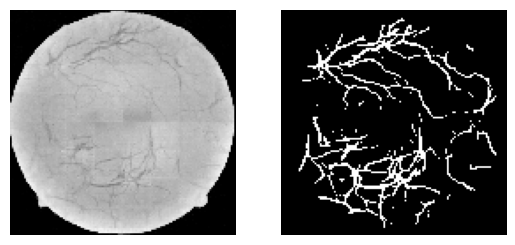

In [42]:
# Sanity check
batch = next(iter(train_loader))
print(batch["img"].shape)
plt.subplot(1, 2, 1)
plt.imshow(batch["img"][0, 0, ...], cmap="gist_gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(batch["mask"][0, 0, ...], cmap="gist_gray")
plt.axis("off")
plt.show()

### Networks creation and losses

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [44]:
def one_hot(input_label, label_nc):
    # One hot encoding function for the labels
    shape_ = list(input_label.shape)
    shape_[1] = label_nc
    label_out = torch.zeros(shape_)
    for channel in range(label_nc):
        label_out[:, channel, ...] = input_label[:, 0, ...] == channel
    return label_out

In [45]:
def picture_results(input_label, input_image, output_image):
    plt.figure(figsize=(4, 1.5))
    plt.subplot(1, 3, 1)
    plt.imshow(torch.argmax(input_label, 1)[0, ...].detach().cpu(), cmap="jet")
    plt.axis("off")
    plt.title("Mask")
    plt.subplot(1, 3, 2)
    plt.imshow(input_image[0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Input image")
    plt.subplot(1, 3, 3)
    plt.imshow(output_image[0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Output image")
    plt.show()

SPADE Diffusion Models require two components:
- Autoencoder, incorporating SPADE normalisation in the decoder blocks
- Diffusion model, operating in the latent space, and incorporating SPADE normalisation in the decoding branch

In [46]:
autoencoder = SPADEAutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_res_blocks=(2, 2, 2, 2),
    channels=(8, 16, 32, 64),
    attention_levels=[False, False, False, False],
    latent_channels=8,
    norm_num_groups=8,
    label_nc=label_nc,
)

In [47]:
diffusion = SPADEDiffusionModelUNet(
    spatial_dims=2,
    in_channels=8,
    out_channels=8,
    num_res_blocks=(2, 2, 2, 2),
    channels=(16, 32, 64, output_shape[0]),
    attention_levels=(False, False, True, True),
    norm_num_groups=16,
    with_conditioning=False,
    label_nc=label_nc,
)

To train the autoencoder, we are using **a Patch-GAN-based adversarial loss**, a **perceptual loss** and a basic **L1 loss** between input and output.

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex").to(device)

In [49]:
discriminator = PatchDiscriminator(
    spatial_dims=2,
    num_layers_d=3,
    channels=16,
    in_channels=1,
    out_channels=1,
)
discriminator = discriminator.to(device)

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01

In [50]:
recon = torch.nn.L1Loss()

In [51]:
optimizer_g = torch.optim.Adam(autoencoder.parameters(), lr=0.0002)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0004)
# For mixed precision training
scaler_g = torch.amp.GradScaler("cuda")
scaler_d = torch.amp.GradScaler("cuda")

## Training the AutoencoderKL

We used the exact same approach as the one from the 2d_ldm_tutorial to train the autoencoder.

In [52]:
# Loss weights and number of epochs
kl_weight = 1e-6
max_epochs = 100
val_interval = 20
adv_weights = 0.01
autoencoder_warm_up_n_epochs = 10
perceptual_weight = 0.001

Train: reconstruction: 0.291140; generator: 0.000000; discriminator: 0.000000; perceptual: 0.024246; kld: 248.354513
Train: reconstruction: 0.044933; generator: 0.000000; discriminator: 0.000000; perceptual: 0.009064; kld: 877.469979


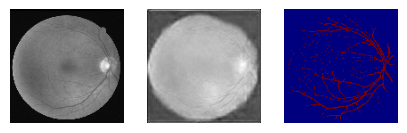

epoch 20 val loss: 0.0648
Train: reconstruction: 0.033210; generator: 0.799910; discriminator: 0.038121; perceptual: 0.003242; kld: 906.836256
Train: reconstruction: 0.026315; generator: 0.874457; discriminator: 0.030440; perceptual: 0.002653; kld: 915.249127


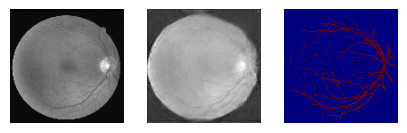

epoch 40 val loss: 0.0507
Train: reconstruction: 0.021635; generator: 0.938929; discriminator: 0.015329; perceptual: 0.002470; kld: 901.898124
Train: reconstruction: 0.020270; generator: 0.941998; discriminator: 0.018152; perceptual: 0.001390; kld: 862.999976


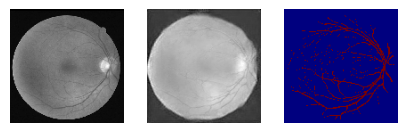

epoch 60 val loss: 0.0464
Train: reconstruction: 0.016389; generator: 0.970950; discriminator: 0.002136; perceptual: 0.001369; kld: 839.486655
Train: reconstruction: 0.015906; generator: 0.973188; discriminator: 0.001818; perceptual: 0.001250; kld: 800.102746


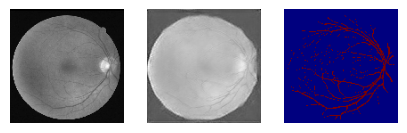

epoch 80 val loss: 0.0458
Train: reconstruction: 0.018006; generator: 0.881202; discriminator: 0.012766; perceptual: 0.001522; kld: 804.456373
Train: reconstruction: 0.014610; generator: 0.980745; discriminator: 0.001616; perceptual: 0.001745; kld: 755.088528


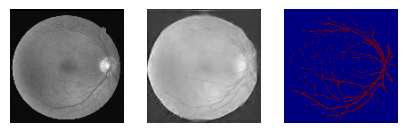

epoch 100 val loss: 0.0463


In [53]:
autoencoder.to(device)

# Loss storage
epoch_recon_losses = []
epoch_perc_losses = []
epoch_kld_losses = []
epoch_gen_losses = []
epoch_disc_losses = []
val_recon_losses = []

for epoch in range(max_epochs):
    autoencoder.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    perceptual_epoch_loss = 0
    kld_epoch_loss = 0
    for batch in train_loader:
        images = batch["img"].to(device)
        labels = one_hot(batch["mask"], label_nc).to(device)
        optimizer_g.zero_grad(set_to_none=True)

        with autocast(device_type="cuda", enabled=True):
            reconstruction, z_mu, z_sigma = autoencoder(images, labels)
            recons_loss = recon(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        if epoch > autoencoder_warm_up_n_epochs:
            with autocast(device_type="cuda", enabled=True):
                optimizer_d.zero_grad(set_to_none=True)
                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_d)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        perceptual_epoch_loss += p_loss.item()
        kld_epoch_loss += kl_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

    num_steps = len(train_loader) + 1
    epoch_recon_losses.append(epoch_loss / num_steps)
    epoch_gen_losses.append(gen_epoch_loss / num_steps)
    epoch_disc_losses.append(disc_epoch_loss / num_steps)
    epoch_perc_losses.append(p_loss / num_steps)
    epoch_kld_losses.append(kld_epoch_loss / num_steps)

    if epoch % 10 == 0:
        msgs = [
            f"Train: reconstruction: {epoch_recon_losses[-1]:4f}",
            f" generator: {epoch_gen_losses[-1]:4f}",
            f" discriminator: {epoch_disc_losses[-1]:4f}",
            f" perceptual: {epoch_perc_losses[-1]:4f}",
            f" kld: {epoch_kld_losses[-1]:4f}",
        ]
        print(";".join(msgs))

    if (epoch + 1) % val_interval == 0:
        autoencoder.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=0):
                images = batch["img"].to(device)
                labels = one_hot(batch["mask"], label_nc).to(device)
                with autocast(device_type="cuda", enabled=True):
                    reconstruction, z_mu, z_sigma = autoencoder(images, labels)
                    recons_loss = recon(images.float(), reconstruction.float())
                val_loss += recons_loss.item()
                # We retrieve the image to plot
                if val_step == 0:
                    reconstruction = reconstruction.detach().cpu()
                    plt.figure(figsize=(5, 3))
                    plt.subplot(1, 3, 1)
                    plt.imshow(images[0, 0, ...].detach().cpu(), cmap="gist_gray")
                    plt.axis("off")
                    plt.subplot(1, 3, 2)
                    plt.imshow(reconstruction[0, 0, ...], cmap="gist_gray")
                    plt.axis("off")
                    plt.subplot(1, 3, 3)
                    plt.imshow(batch["mask"][0, 0, ...].detach().cpu(), cmap="jet")
                    plt.axis("off")
                    plt.show()

        val_loss /= max(val_step, 1)
        val_recon_losses.append(val_loss)
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")

del discriminator
del perceptual_loss
torch.cuda.empty_cache()

## Training the diffusion model

Likewise, we use the same approach as in the 2d_ldm_tutorial.

In [54]:
scheduler = DDPMScheduler(num_train_timesteps=500, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)
optimizer = torch.optim.Adam(diffusion.parameters(), lr=1e-4)
inferer = LatentDiffusionInferer(scheduler, scale_factor=1.0)

Epoch 0 / 200
training loss: 0.4727
Epoch 10 / 200
training loss: 0.4373
Epoch 20 / 200
training loss: 0.3934
Epoch 30 / 200
training loss: 0.4100
Epoch 39 val loss: 0.3411


100%|██████████| 500/500 [00:14<00:00, 34.03it/s]


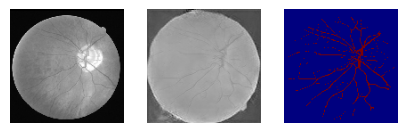

Epoch 40 / 200
training loss: 0.4042
Epoch 50 / 200
training loss: 0.3290
Epoch 60 / 200
training loss: 0.3226
Epoch 70 / 200
training loss: 0.3859
Epoch 79 val loss: 0.2644


100%|██████████| 500/500 [00:14<00:00, 34.12it/s]


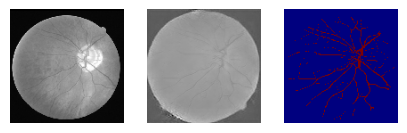

Epoch 80 / 200
training loss: 0.3779
Epoch 90 / 200
training loss: 0.3341
Epoch 100 / 200
training loss: 0.3161
Epoch 110 / 200
training loss: 0.3225
Epoch 119 val loss: 0.3201


100%|██████████| 500/500 [00:14<00:00, 34.23it/s]


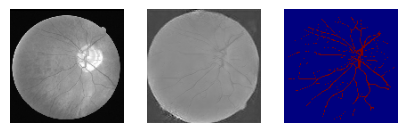

Epoch 120 / 200
training loss: 0.3409
Epoch 130 / 200
training loss: 0.3294
Epoch 140 / 200
training loss: 0.3695
Epoch 150 / 200
training loss: 0.2931
Epoch 159 val loss: 0.2552


100%|██████████| 500/500 [00:14<00:00, 34.26it/s]


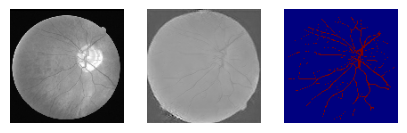

Epoch 160 / 200
training loss: 0.3275
Epoch 170 / 200
training loss: 0.3412
Epoch 180 / 200
training loss: 0.3676
Epoch 190 / 200
training loss: 0.3098
Epoch 199 val loss: 0.2558


100%|██████████| 500/500 [00:14<00:00, 34.22it/s]


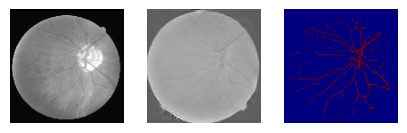

In [56]:
diffusion = diffusion.to(device)
max_epochs = 200
val_interval = 40
epoch_losses = []
val_losses = []
scaler = GradScaler("cuda")

for epoch in range(max_epochs):
    if epoch % 10 == 0:
        print("Epoch %d / %d" % (epoch, max_epochs))
    diffusion.train()
    autoencoder.eval()
    epoch_loss = 0
    for batch in train_loader:
        images = batch["img"].to(device)
        labels = one_hot(batch["mask"], label_nc).to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type="cuda", enabled=True):
            z_mu, z_sigma = autoencoder.encode(images)
            z = autoencoder.sampling(z_mu, z_sigma)
            noise = torch.randn_like(z).to(device)
            timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device).long()
            noise_pred = inferer(
                inputs=images,
                diffusion_model=diffusion,
                noise=noise,
                timesteps=timesteps,
                autoencoder_model=autoencoder,
                seg=labels,
            )
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

    epoch_losses.append(epoch_loss / (len(train_loader) + 1))
    if epoch % 10 == 0:
        print("training loss: %.4f" % (epoch_losses[-1]))

    if (epoch + 1) % val_interval == 0:
        diffusion.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                images = batch["img"].to(device)
                labels = one_hot(batch["mask"], label_nc).to(device)
                with autocast(device_type="cuda", enabled=True):
                    z_mu, z_sigma = autoencoder.encode(images)

                    z = autoencoder.sampling(z_mu, z_sigma)
                    noise = torch.randn_like(z).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device
                    ).long()
                    noise_pred = inferer(
                        inputs=images,
                        diffusion_model=diffusion,
                        noise=noise,
                        timesteps=timesteps,
                        autoencoder_model=autoencoder,
                        seg=labels,
                    )

                    loss = F.mse_loss(noise_pred.float(), noise.float())

                val_loss += loss.item()
        val_loss /= len(val_loader) + 1
        val_losses.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        # Sampling image during training. We use the last segmentation of our loader
        z = torch.randn((labels.shape[0], 8, 16, 16))
        z = z.to(device)
        scheduler.set_timesteps(num_inference_steps=500)
        with autocast(device_type="cuda", enabled=True):
            decoded = inferer.sample(
                input_noise=z, diffusion_model=diffusion, scheduler=scheduler, autoencoder_model=autoencoder, seg=labels
            )
        plt.figure(figsize=(5, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(images[0, 0, ...].detach().cpu(), cmap="gist_gray")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.imshow(decoded[0, 0, ...].detach().cpu(), cmap="gist_gray")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.imshow(batch["mask"][0, 0, ...].detach().cpu(), cmap="jet")
        plt.axis("off")
        plt.show()

100%|██████████| 500/500 [00:14<00:00, 34.78it/s]


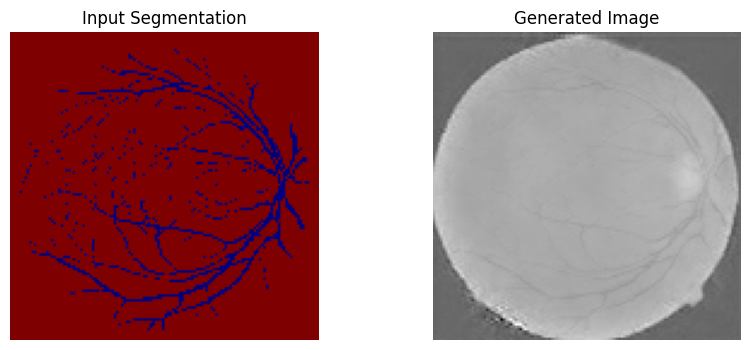

In [59]:
## Generate Outside of training
diffusion.eval()
autoencoder.eval()

# Dummy noise and label (or real one from your val_loader)
z = torch.randn((1, 8, 16, 16)).to(device)
segmentation = next(iter(val_loader))["mask"][:1].to(device)
segmentation = one_hot(segmentation, label_nc).to(device)

scheduler.set_timesteps(num_inference_steps=500)
with torch.no_grad(), autocast(device_type="cuda", enabled=True):
    generated = inferer.sample(
        input_noise=z,
        diffusion_model=diffusion,
        scheduler=scheduler,
        autoencoder_model=autoencoder,
        seg=segmentation,
    )

# Visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(segmentation[0, 0].detach().cpu(), cmap="jet")
plt.axis("off")
plt.title("Input Segmentation")

plt.subplot(1, 2, 2)
plt.imshow(generated[0, 0].detach().cpu(), cmap="gist_gray")
plt.axis("off")
plt.title("Generated Image")

plt.show()  # Or use plt.savefig("gen.png")
